# SCOOT Time Series Methods Demo

In [1]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from SpatialScan.preprocessing import *
from SpatialScan.synthetic import *
from SpatialScan.timeseries import *
import time

In [2]:
df = pd.read_csv('ActonAprilJune.csv', index_col=False, parse_dates=[4, 5])

In [3]:
DF=data_preprocessor(df, max_anom = 5, N_sigma = 3, repeats = 4, percentage_missing=3)

Using the 24-day rolling median to remove outliers ...
Using 4 iterations to remove points outside of 3 sigma from the rolling median ...
Calculating threshold(s): Iteration 4 of 4...
Threshold(s) calculated.

Dropping detectors with more than 5 anomalies...
Filling in missing dates and times. Reindexing on date ...
Dropping detectors with sufficiently high amounts of missing data (>3%)...
854 detectors dropped: {'N23/013q1', 'N12/025a1', 'N27/289f2', 'N02/094a1', 'N10/170b1', 'N23/004m2', 'N25/012a3', 'N27/239a2', 'N01/038a3', 'N25/223b2', 'N24/011t2', 'N01/170b1', 'N11/123d1', 'N24/040a2', 'N23/090a1', 'N11/174b1', 'N24/058b1', 'N12/011y1', 'N02/001a1', 'N21/010f1', 'N27/219c2', 'N01/108e1', 'N01/122d1', 'N01/231c1', 'N27/096p2', 'N11/016b1', 'N28/025b1', 'N28/029a1', 'N27/011c1', 'N27/048a3', 'N10/042e1', 'N12/003b1', 'N10/164a2', 'N10/172b1', 'N25/041g3', 'N01/561f1', 'N01/170c1', 'N01/310c1', 'N12/037b2', 'N24/011t1', 'N01/226c1', 'N23/174a1', 'N27/011a1', 'N11/091g2', 'N11/150x1'

N11/009e1


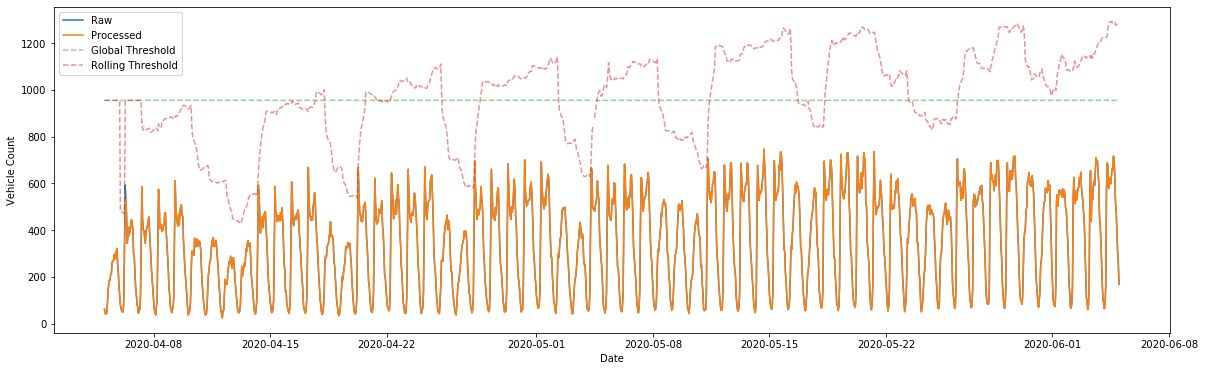

In [4]:
plot_processing(df, DF)

In [5]:
detectors=DF["detector_id"].unique()

In [6]:
sample=np.random.choice(detectors, 50)

## Holt-Winters
The multiplicative Holt–Winters’ (HW) method is a more dynamic forecasting method that takes into account smaller periodic trends, as well as long term trends (such as seasonal trends). It has three main components: the smoothed value $S_t$ , trend component $Tt$ , and the periodic component $I_t$

### $
S_{t}=\alpha \frac{c_{i}^{t}}{I_{t+24}}+(1-\alpha)\left(S_{t+1}+T_{t+1}\right) \\
T_{t}=\beta\left(S_{t}-S_{t+1}\right)+(1-\beta) T_{t+1} \\
I_{t}=\gamma \frac{c_{i}^{t}}{S_{t}}+(1-\gamma) I_{t+24}$

These are iterated through historical data, and then extended to the forecasting period, where the baseline estimate for the next hour is then given by $b^t_i=\left(S_{t+1}+T_{t+1}\right) I_{t+24}$. the baseline is then replaced for count in the equations above, and iterated across the forecasting period.

Strengths: Very quick, simple

Weaknesses: Over simplistic, does not give uncertainty estimates, does not extend well to longer forecasts

In [8]:
CB_HW=count_baseline(DF, 30, 2, detectors=sample, alpha = 0.06, beta = 0.02, gamma = 0.4)

Input dataframe contains data spanning 2020-04-05 00:00:00 to 2020-06-05 00:00:00.
Using data from 2020-05-04 00:00:00 to 2020-06-03 00:00:00, to forecast counts
 between 2020-06-03 00:00:00 and 2020-06-05 00:00:00 for 50 detectors using HW method...
Forecasting complete.


N22/146e1


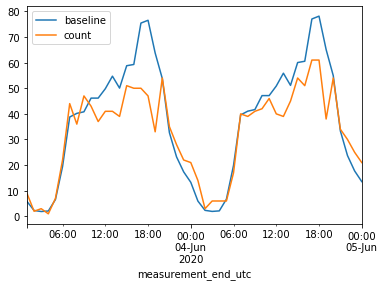

In [9]:
forecast_plot(CB_HW)

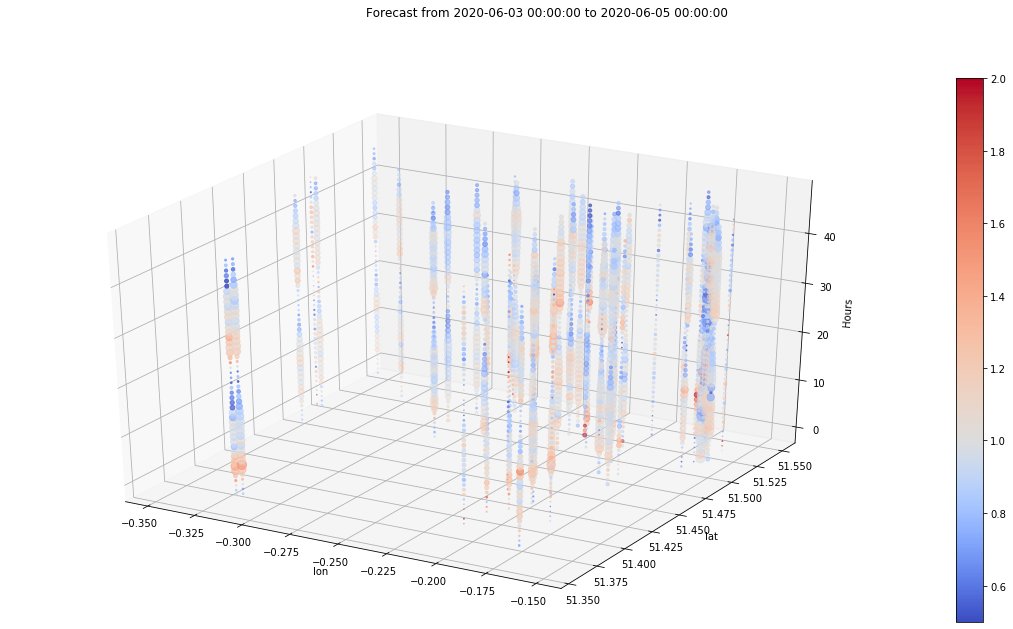

In [10]:
CB_plot(CB_HW)

## Gaussian Process
for the sake of our GP modelling we shall consider two kernels: the standard squared exponential kernel $k_{\mathrm{SE}}$ and the periodic kernel $k_{\mathrm{P}}$, given below.
        
#### $
k_{\mathrm{SE}}\left(\boldsymbol{x}, \boldsymbol{x}^{\prime}\right)=\alpha^{2} \exp \left(-\frac{1}{2} \frac{\left(x_{d}-x_{d}^{\prime}\right)^{2}}{l}\right)$

#### $
k_{\mathrm{P}}\left(\boldsymbol{x}, \boldsymbol{x}^{\prime}\right)=\alpha^{2} \exp \left(-\frac{1}{2}\left(\frac{\sin \left(\tau\left(x_{d}-x_{d}^{\prime}\right)\right)}{l}\right)^{2}\right) 
$

for the periodic elements likely from traffic forecasts, we need the periodic kernel. Considering the patterns associated with traffic forecast, we suggest a tailored kernel composed of the sum of three kernels:

$k_1(x, x^\prime)$ a periodic kernel with a periodicity hyper-parameter equal to 24 hours to capture the daily periodic patterns 
    
$k_2(x, x^\prime)$ a periodic kernel with a periodicity hyper-parameter equal to 24 $\times$ 7 hours to capture the day-of-the-week periodicity
    
$k_3(x, x^\prime)$ a squared exponential kernel for deviations and underlying trends

Our tailored kernel will be using a combination of these three, $k(x, x^\prime) = k_1(x, x^\prime) \times k_2(x, x^\prime) + k_3(x, x^\prime)$, thus leaving six hyper-parameters to fine tune, three variances and three length scales. These are optimised using GPflows optimisation module

In [11]:
CB_GP=count_baseline(DF, 20, 2, detectors=sample, method="GP")

Input dataframe contains data spanning 2020-04-05 00:00:00 to 2020-06-05 00:00:00.
Using data from 2020-05-14 00:00:00 to 2020-06-03 00:00:00, to forecast counts
 between 2020-06-03 00:00:00 and 2020-06-05 00:00:00 for 50 detectors using GP method...
Forecasting complete.


N27/020b1


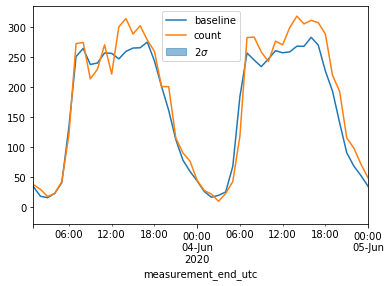

In [12]:
forecast_plot(CB_GP)

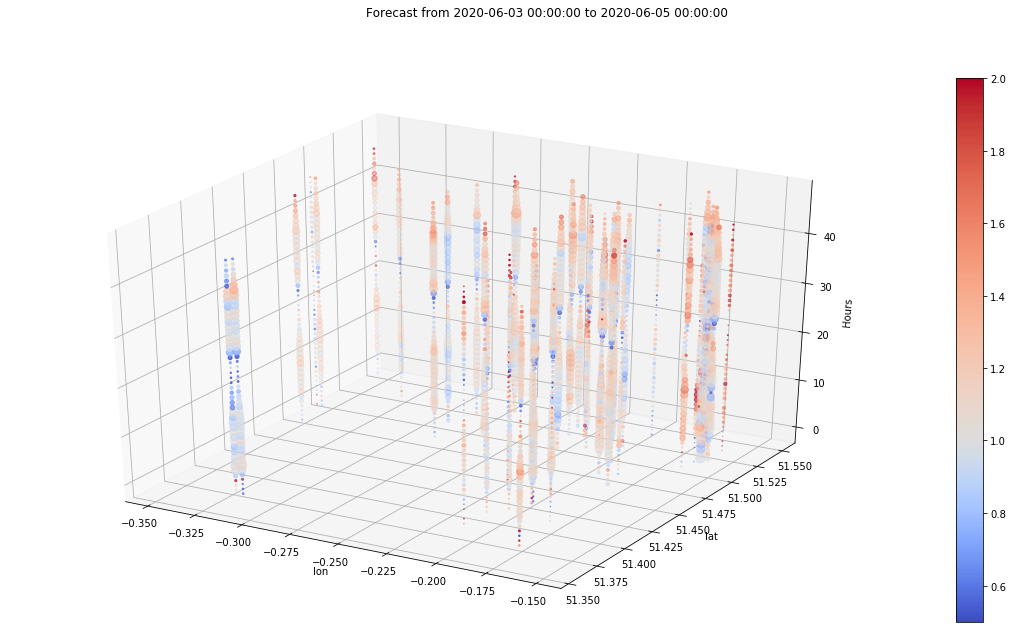

In [13]:
CB_plot(CB_GP)

In [14]:
kern_pD = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
kern_pW = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
kern_SE = gpflow.kernels.SquaredExponential()
kern_W = gpflow.kernels.White()
kern_M = gpflow.kernels.Matern52()

kern_M.lengthscales.assign(1.0)
kern_pD.period.assign(24.0)
# kern_pD.base_kernel.variance.assign(10)
kern_pW.period.assign(168.0)
# kern_pW.base_kernel.variance.assign(10)

k = kern_SE*(kern_pD + kern_pW) + kern_M

In [15]:
CB_GP2=count_baseline(DF, 20, 2, detectors=sample, method="GP", kern=k)

Input dataframe contains data spanning 2020-04-05 00:00:00 to 2020-06-05 00:00:00.
Using data from 2020-05-14 00:00:00 to 2020-06-03 00:00:00, to forecast counts
 between 2020-06-03 00:00:00 and 2020-06-05 00:00:00 for 50 detectors using GP method...
Forecasting complete.


N22/172a1


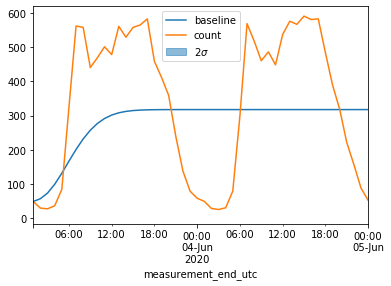

In [16]:
forecast_plot(CB_GP2)

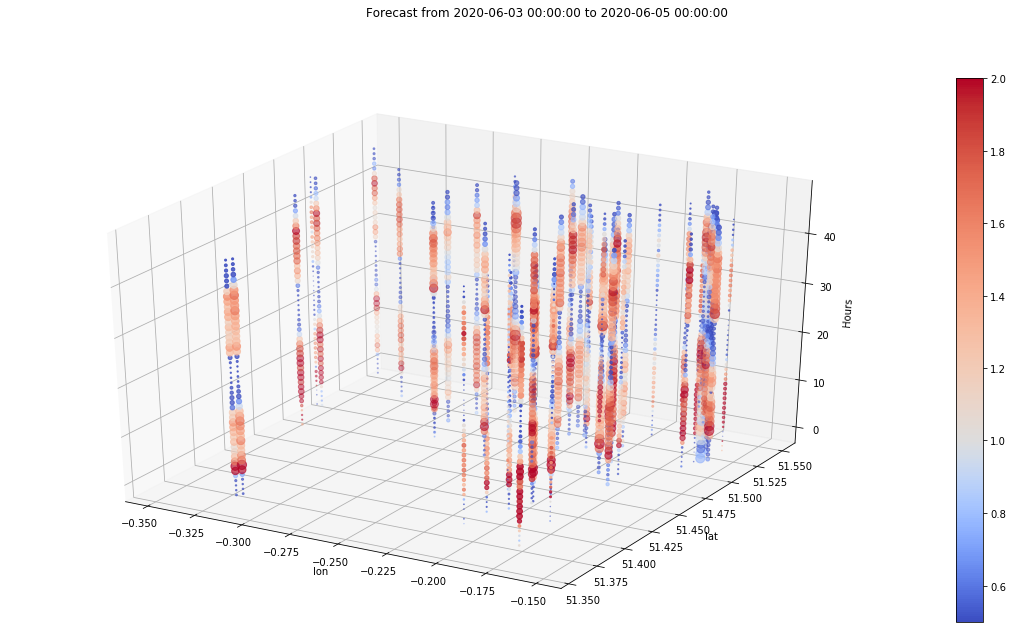

In [17]:
CB_plot(CB_GP2)

##  LSTM
The LSTM that would be used for this task would have input nodes equal to the number of hours in the lookback period, and output nodes equal to the number of hours in the forecasting period. However, LSTM's can be slow and maybe too powerful, furthermore they require a huge amount of data to train

In [18]:
CB_LS=count_baseline(DF, 7, 2, detectors=sample, method="LSTM")

Input dataframe contains data spanning 2020-04-05 00:00:00 to 2020-06-05 00:00:00.
Using data from 2020-05-27 00:00:00 to 2020-06-03 00:00:00, to forecast counts
 between 2020-06-03 00:00:00 and 2020-06-05 00:00:00 for 50 detectors using LSTM method...
Forecasting complete.


N11/153z1


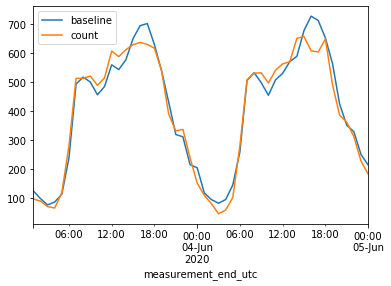

In [19]:
forecast_plot(CB_LS)

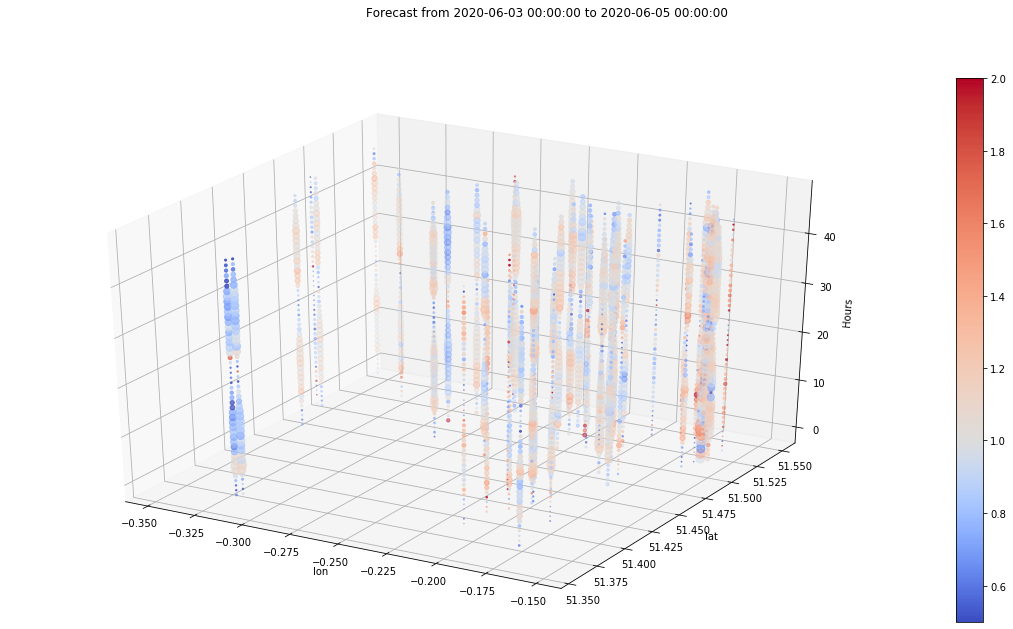

In [20]:
CB_plot(CB_LS)